In [29]:
import pandas as pd
import numpy as np
import mne
import glob
from tqdm import tqdm

from EegHelper.EegData import EegDataPoint, EegDataset, files_to_datapoints
from EegHelper.DataIO import DataBuilder, split_main_data

%matplotlib inline

#Following two are so that external files are auto loaded after edit
%load_ext autoreload
%autoreload 2
#mne outputs so much stuff, so just set log level
mne.set_log_level('error')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
files = glob.glob('./MindBigData-EP-v1.0/*.csv')
all_points, all_labels = files_to_datapoints(epoc_files = files, first_n=len(files)) #first_n = 500 by default. Apply first_n = len(files) to load all

Loading epoc data...


100%|██████████| 65034/65034 [03:43<00:00, 291.22it/s]


In [31]:
print("Num points EPOC:", len(all_points))
print("Num labels EPOC:", len(all_labels))
print("Labels EPOC:", all_labels)
print("------------------------------------")
print("Data shape EPOC", all_points[0].raw_data.shape)

Num points EPOC: 64629
Num labels EPOC: 11
Labels EPOC: ['6', '8', '4', '5', '9', '1', '0', '7', '3', '2', '-1']
------------------------------------
Data shape EPOC (256, 14)


In [33]:
for point in tqdm(all_points):
    point.full_clean(channels=['T7', 'P7', 'P8', 'T8'])

100%|██████████| 64629/64629 [03:47<00:00, 283.81it/s]


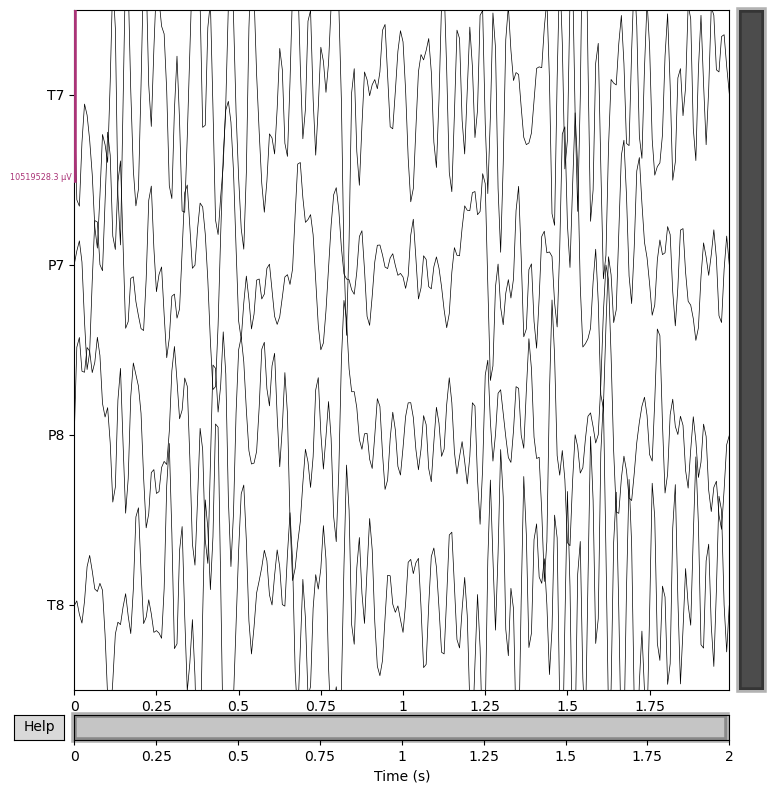

In [34]:
all_points[0].mne_object.plot(scalings = 'auto');

In [35]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
from torch.optim import Adam, SGD
import torch.nn as nn
from torch.nn import MSELoss, CrossEntropyLoss
from models.EegClassifierA import Classifier
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [36]:
batch_size = 32
num_workers = 4

dataset = EegDataset(data_points=all_points, labels=all_labels)
train, test = train_test_split(dataset, train_size=0.8, shuffle=True)

train_dataloader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_dataloader = DataLoader(test, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = Classifier(classes_count=11).to(device=device)

optimizer = Adam(model.parameters(), lr=0.01)                                           
loss_function = nn.CrossEntropyLoss()

n_epochs = 20

validation_data = []
training_data = []

for epoch in range(n_epochs):
    
    print(f'Epoch {epoch+1}/{n_epochs}')
    model.train()

    train_loss = 0.0
    train_accuracy = 0.0

    val_loss = 0.0
    val_accuracy = 0.0

    for data, labels in tqdm(train_dataloader):
        
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(data)

        #Loss
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().data*data.size(0)

        #Prediction
        expected_prediction = []
        for i in labels:
            expected_prediction.append(((i == 1).nonzero(as_tuple=True)[0]))
        expected_prediction = torch.Tensor(expected_prediction).type(torch.int16).to(device)
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy+=int(torch.sum(prediction==expected_prediction))        
        
    
    train_loss/=(len(train_dataloader))
    train_accuracy/=(len(train_dataloader) * batch_size)
    training_data.append(train_loss.item())

    print('Epoch train loss:', train_loss.item())
    print('Epoch accuracy:', train_accuracy)

    print("------------------Validating--------------------")
    model.eval()
    
    for val_data, val_labels in test_dataloader:
        val_data = val_data.to(device)
        val_labels = val_labels.to(device)
        
        outputs_val = model(val_data)
        #Accuracy
        expected_prediction_val = list()
        for i in val_labels:
            expected_prediction_val.append(((i == 1).nonzero(as_tuple=True)[0]))
        expected_prediction_val = torch.Tensor(expected_prediction_val).type(torch.int16).to(device)
        _, prediction_val = torch.max(outputs_val, 1)
        val_accuracy+=int(torch.sum(prediction_val==expected_prediction_val))
        #Loss
        val_loss += loss_function(outputs_val, val_labels)

    val_loss /= len(test_dataloader)
    val_accuracy /= (len(test_dataloader)*batch_size)
    validation_data.append(val_loss.item())
    print('Validation loss:',val_loss.item())
    print('Validation accuracy:',val_accuracy)

cpu
Epoch 1/20


  0%|          | 0/1616 [00:00<?, ?it/s]

/home/andrewheschl/Documents/Eeg_AIRS_Project/models/EegClassifierA.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


KeyboardInterrupt: 

[2.4397072792053223, 2.4397072792053223, 2.441929578781128, 2.4408183097839355, 2.4430408477783203, 2.441929340362549, 2.443040609359741, 2.443040609359741, 2.441929340362549, 2.4408183097839355, 2.4430408477783203, 2.4397072792053223, 2.441929340362549, 2.4430408477783203, 2.443040370941162, 2.441929340362549, 2.441929340362549, 2.443040370941162, 2.4408183097839355, 2.441929578781128]


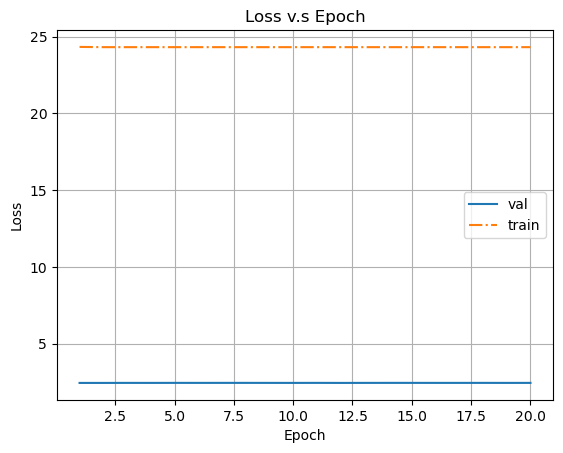

In [ ]:
print(validation_data)
x = [i+1 for i in range(len(validation_data))]

plt.plot(x, validation_data, label ='val')
plt.plot(x, training_data, '-.', label ='train')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title('Loss v.s Epoch')
plt.grid()

plt.show()